In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

from scipy.stats import binned_statistic

In [2]:
colors = {'weak': 'tab:blue', 'mid':'tab:green', 'strong':'tab:red'}


In [3]:
erfs = pd.read_csv('../data_output/fair_ERFaer/ssp119.csv', index_col='year')
mean_erfs = erfs[2005.5:2014.5].mean(axis=0)
mean_erfs.describe()

count    3751.000000
mean       -1.152634
std         0.325839
min        -2.307060
25%        -1.367865
50%        -1.149490
75%        -0.936880
max         0.249950
dtype: float64

In [4]:
ecs_constraints = pd.read_csv('../data_output/ecs.csv', index_col=0)
erf_constraints = pd.read_csv('../data_output/aerosol_distributions.csv', index_col=0)

In [5]:
ssp_119_T = pd.read_csv('../data_output/fair_temperature/ssp119.csv', index_col='year')
ssp_126_T = pd.read_csv('../data_output/fair_temperature/ssp126.csv', index_col='year')

observations = pd.read_csv('../data_input/gsat/ar6_four_set_mean_gmst.csv', index_col='Year')

In [6]:
ssp_119_erf = pd.read_csv('../data_output/fair_ERFaer/ssp119.csv', index_col='year')
ssp_126_erf = pd.read_csv('../data_output/fair_ERFaer/ssp126.csv', index_col='year')

/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_56291/2175046231.py:4: UserWarning: shading value 'gourard' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(ssp_119_T[1980:].index, points, temp_prob, shading='gourard')


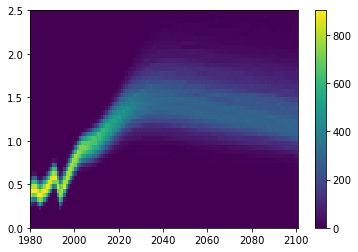

In [7]:
bins = np.linspace(0, 2.5, 51)
points = np.linspace(0.025, 2.475, 50)
temp_prob = ssp_119_T.apply(lambda x: np.histogram(x, bins=bins, density=False)[0], axis=1, result_type='expand')[1980:].values.T
plt.pcolormesh(ssp_119_T[1980:].index, points, temp_prob, shading='gourard')
plt.colorbar()

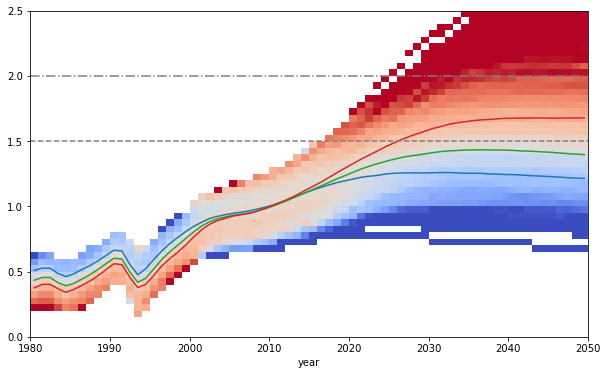

In [8]:
plt.figure(figsize=(10,6))
# p=plt.pcolormesh(ssp_119_erf.index[230:330], bins, np.stack(res)[230:330].T, cmap='RdBu', vmin=-1.5, vmax=-0.5)#, edgecolor='face', shading='auto')
p=plt.pcolormesh(ssp_119_erf[1980:2050].index, points, 
                 ssp_119_T.apply(lambda x: binned_statistic(x, mean_erfs, bins=bins, statistic='mean')[0], axis=1, result_type='expand')[1980:2050].values.T,
                cmap='coolwarm_r', vmin=-1.6, vmax=-0.6)

#plt.savefig('myfig.png') # or fig.canvas.draw()

def alpha_to_white(color, alpha):
    white = np.array([1,1,1])
#     alpha = color[-1]
    color = color[:-1]
    return alpha*color + (1 - alpha)*white

# normed_temp_prob = temp_prob/np.percentile(temp_prob, 99)
normed_temp_prob = (temp_prob/temp_prob.max(axis=0)) * 1.5

fcolors = p.get_facecolors()
fcolors = np.array([alpha_to_white(color, prob) for color, prob in zip(fcolors, normed_temp_prob[:, :69].flatten())])
# colors = np.array([np.append(color[:3], prob) for color, prob in zip(colors, normed_temp_prob[:, :120].flatten())])
p.set_facecolors(fcolors)


# plt.colorbar()
# print(colors.shape)
# print(temp_prob[:, :99].flatten().shape)
# for fc, j in zip(colors, normed_temp_prob[:, :99].flatten()):
# #     fc = alpha_to_white(fc, j) # Set the alpha value of the RGBA tuple using m2
#     fc[3] = j
# #     ec='k'

# def alpha_to_white(color):
#     white = np.array([1,1,1])
#     alpha = color[-1]
#     color = color[:-1]
#     return alpha*color + (1 - alpha)*white

# colors = np.array([alpha_to_white(color) for color in colors])
# p.set_facecolors(colors)

ssp_119_T.loc[1980:2050, erf_constraints.weak_aer.values].median(axis=1).plot(c=colors['weak'])
ssp_119_T.loc[1980:2050, erf_constraints.mid_aer.values].median(axis=1).plot(c=colors['mid'])
ssp_119_T.loc[1980:2050, erf_constraints.strong_aer.values].median(axis=1).plot(c=colors['strong'])

plt.gca().axhline(1.5, ls='--', c='grey')
plt.gca().axhline(2, ls='-.', c='grey')

plt.show()



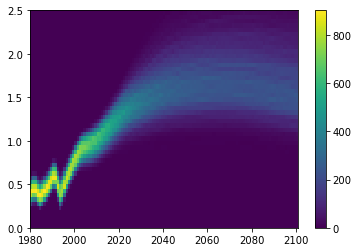

In [9]:
#bins = np.linspace(0, 2.5, 50)
temp_prob = ssp_126_T.apply(lambda x: np.histogram(x, bins=bins, density=False)[0], axis=1, result_type='expand')[1980:].values.T
plt.pcolormesh(ssp_126_T[1980:].index, points, temp_prob)
plt.colorbar()

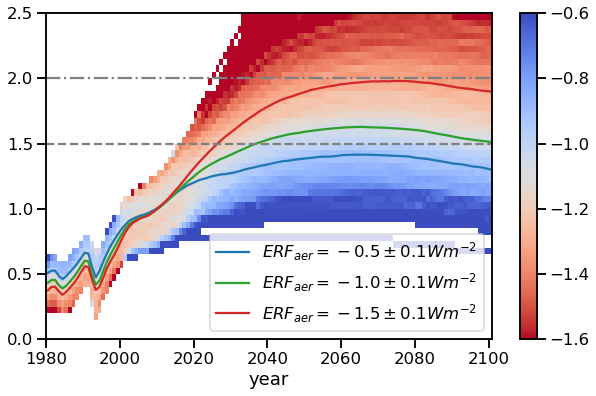

In [10]:
with sns.plotting_context('talk'):

    plt.figure(figsize=(10,6))
    # p=plt.pcolormesh(ssp_119_erf.index[230:330], bins, np.stack(res)[230:330].T, cmap='RdBu', vmin=-1.5, vmax=-0.5)#, edgecolor='face', shading='auto')
    p=plt.pcolormesh(ssp_126_T[1980:].index, points, 
                     ssp_126_T.apply(lambda x: binned_statistic(x, mean_erfs, bins=bins, statistic='mean')[0], axis=1, result_type='expand')[1980:].values.T,
                    cmap='coolwarm_r', vmin=-1.6, vmax=-0.6)
    plt.colorbar()
    #plt.savefig('myfig.png') # or fig.canvas.draw()

    def alpha_to_white(color, alpha):
        white = np.array([1,1,1])
    #     alpha = color[-1]
        color = color[:-1]
        return alpha*color + (1 - alpha)*white

    normed_temp_prob = (temp_prob/temp_prob.max(axis=0)) * 2

    fcolors = p.get_facecolors()
    fcolors = np.array([alpha_to_white(color, prob) for color, prob in zip(fcolors, normed_temp_prob[:, :120].flatten())])
    # colors = np.array([np.append(color[:3], prob) for color, prob in zip(colors, normed_temp_prob[:, :120].flatten())])
    p.set_facecolors(fcolors)


    ssp_126_T.loc[1980:, erf_constraints.weak_aer.values].median(axis=1).plot(label='$ERF_{aer}=-0.5\pm0.1Wm^{-2}$', c=colors['weak'])
    ssp_126_T.loc[1980:, erf_constraints.mid_aer.values].median(axis=1).plot(label='$ERF_{aer}=-1.0\pm0.1Wm^{-2}$', c=colors['mid'])
    ssp_126_T.loc[1980:, erf_constraints.strong_aer.values].median(axis=1).plot(label='$ERF_{aer}=-1.5\pm0.1Wm^{-2}$', c=colors['strong'])
    
    plt.gca().axhline(1.5, ls='--', c='grey')
    plt.gca().axhline(2, ls='-.', c='grey')
    plt.legend()
    plt.show()




/Users/chris/anaconda3/envs/ar6-aerosol-uncertainty/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


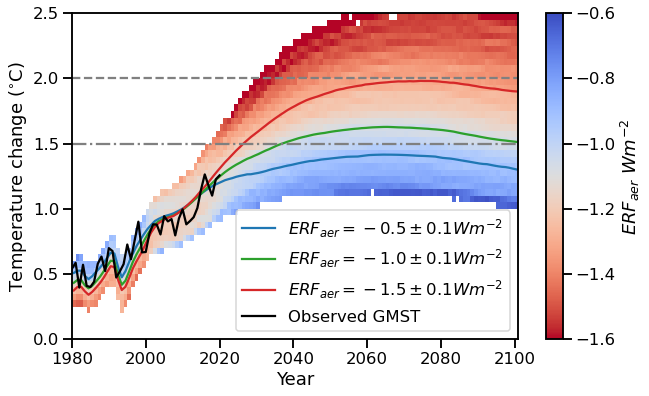

In [11]:
with sns.plotting_context('talk'):

    normed_temp_prob = (temp_prob/temp_prob.max(axis=0))
    
    def get_mean_erf(s):
        mean = binned_statistic(s, mean_erfs, bins=bins, statistic='mean')[0]
        count = np.histogram(s, bins=bins, density=True)[0]
        return np.where(count>0.1, mean, np.nan)
    
    plt.figure(figsize=(10,6))
    # p=plt.pcolormesh(ssp_119_erf.index[230:330], bins, np.stack(res)[230:330].T, cmap='RdBu', vmin=-1.5, vmax=-0.5)#, edgecolor='face', shading='auto')
    p=plt.pcolormesh(ssp_126_T[1980:].index, points, 
                     ssp_126_T.apply(get_mean_erf, axis=1, result_type='expand')[1980:].values.T,
                    cmap='coolwarm_r', vmin=-1.6, vmax=-0.6)
    plt.colorbar(label='$ERF_{aer}$ $Wm^{-2}$')

    ssp_126_T.loc[1980:, erf_constraints.weak_aer.values].median(axis=1).plot(label='$ERF_{aer}=-0.5\pm0.1Wm^{-2}$', c=colors['weak'])
    ssp_126_T.loc[1980:, erf_constraints.mid_aer.values].median(axis=1).plot(label='$ERF_{aer}=-1.0\pm0.1Wm^{-2}$', c=colors['mid'])
    ssp_126_T.loc[1980:, erf_constraints.strong_aer.values].median(axis=1).plot(label='$ERF_{aer}=-1.5\pm0.1Wm^{-2}$', c=colors['strong'])
    
    # Save these for the next plot...
    handles, labels = plt.gca().get_legend_handles_labels()
    
    observations.loc[1980:].rename(columns=dict(GMST='Observed GMST')).plot(ax=plt.gca(), color='k')
    
    plt.gca().axhline(1.5, ls='-.', c='grey')
    plt.gca().axhline(2, ls='--', c='grey')
    plt.setp(plt.gca(), xlabel='Year', ylabel='Temperature change ($^{\circ}$C)')
    plt.legend()
#     plt.savefig("Figure_1.png")
    plt.show()
    




In [12]:
def get_robust_errs(df, confidence=0.1):
    # Get values suitable for errorbars
    return np.diff(df.quantile([confidence, 0.5, 1-confidence]))[:, np.newaxis]

get_robust_errs(ssp_126_T.iloc[-1, erf_constraints.weak_aer.values])

array([[0.2628 ],
       [0.17206]])

/Users/chris/anaconda3/envs/ar6-aerosol-uncertainty/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
posx and posy should be finite values


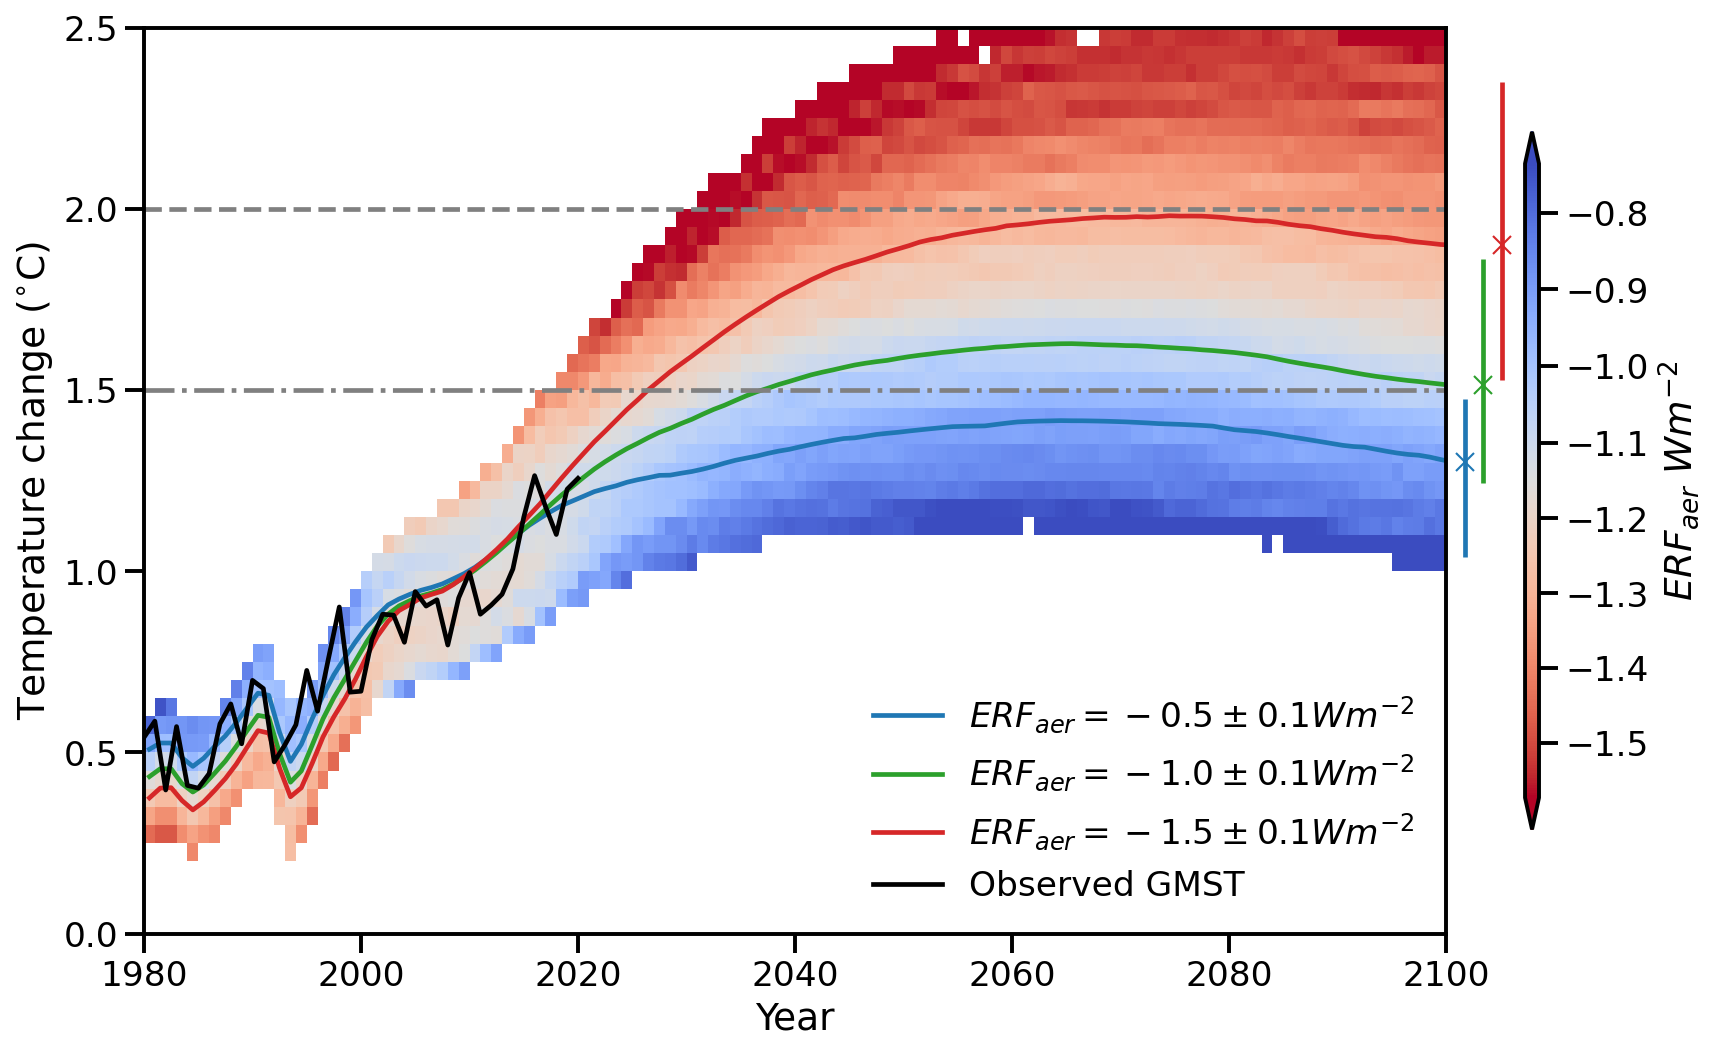

In [13]:

with sns.plotting_context('talk'):

    normed_temp_prob = (temp_prob/temp_prob.max(axis=0))
    
    def get_mean_erf(s):
        mean = binned_statistic(s, mean_erfs, bins=bins, statistic='mean')[0]
        count = np.histogram(s, bins=bins, density=True)[0]
        return np.where(count>0.1, mean, np.nan)
#         return mean
    
    fig = plt.figure(figsize=(12,8), dpi=150)
    
    gs = fig.add_gridspec(1, 15,wspace=0.)
    ax = fig.add_subplot(gs[0,:-1])

    divnorm = TwoSlopeNorm(*mean_erfs.quantile([0.5, 0.1, 0.9]).values)
    
    # p=plt.pcolormesh(ssp_119_erf.index[230:330], bins, np.stack(res)[230:330].T, cmap='RdBu', vmin=-1.5, vmax=-0.5)#, edgecolor='face', shading='auto')
    p=plt.pcolormesh(ssp_126_T[1980:].index, points, 
                     ssp_126_T.apply(get_mean_erf, axis=1, result_type='expand')[1980:].values.T,
                    cmap='coolwarm_r', norm=divnorm)
    

    ssp_126_T.loc[1980:, erf_constraints.weak_aer.values].median(axis=1).plot(label='$ERF_{aer}=-0.5\pm0.1Wm^{-2}$', c=colors['weak'])
    ssp_126_T.loc[1980:, erf_constraints.mid_aer.values].median(axis=1).plot(label='$ERF_{aer}=-1.0\pm0.1Wm^{-2}$', c=colors['mid'])
    ssp_126_T.loc[1980:, erf_constraints.strong_aer.values].median(axis=1).plot(label='$ERF_{aer}=-1.5\pm0.1Wm^{-2}$', c=colors['strong'])
    
    # Save these for the next plot...
    handles, labels = plt.gca().get_legend_handles_labels()
    
    observations.loc[1980:].rename(columns=dict(GMST='Observed GMST')).plot(ax=plt.gca(), color='k')
    
    plt.gca().axhline(1.5, ls='-.', c='grey')
    plt.gca().axhline(2, ls='--', c='grey')
    plt.setp(plt.gca(), xlim=[1980, 2100], xlabel='Year', ylabel='Temperature change ($^{\circ}$C)')
    plt.legend(frameon=False)
    
    # Do the end of century ranges
    ax1 = fig.add_subplot(gs[0,-1])
    ax1.errorbar([-1.],
                 ssp_126_T.iloc[-1, erf_constraints.weak_aer.values].median(),
                 get_robust_errs(ssp_126_T.iloc[-1, erf_constraints.weak_aer.values]), fmt='x', c=colors['weak']
                )
    ax1.errorbar([0],
                 ssp_126_T.iloc[-1, erf_constraints.mid_aer.values].median(),
                 get_robust_errs(ssp_126_T.iloc[-1, erf_constraints.mid_aer.values]), fmt='x', c=colors['mid']
                )
    ax1.errorbar([1.],
                 ssp_126_T.iloc[-1, erf_constraints.strong_aer.values].median(),
                 get_robust_errs(ssp_126_T.iloc[-1, erf_constraints.strong_aer.values]), fmt='x', c=colors['strong']
                )
    ax1.axis('off')
    plt.setp(ax1, xlim=[-2, 2], ylim=[0., 2.5])
    
#     cbar_ax = fig.add_subplot(gs[0,-2])
    
    plt.colorbar(p, extend='both', label='$ERF_{aer}$ $Wm^{-2}$', ax=ax1, aspect=50)

#     plt.tight_layout()
    plt.savefig("../plots/Figure_1.png", bbox_inches="tight")
    plt.show()
    

/Users/chris/anaconda3/envs/ar6-aerosol-uncertainty/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
posx and posy should be finite values


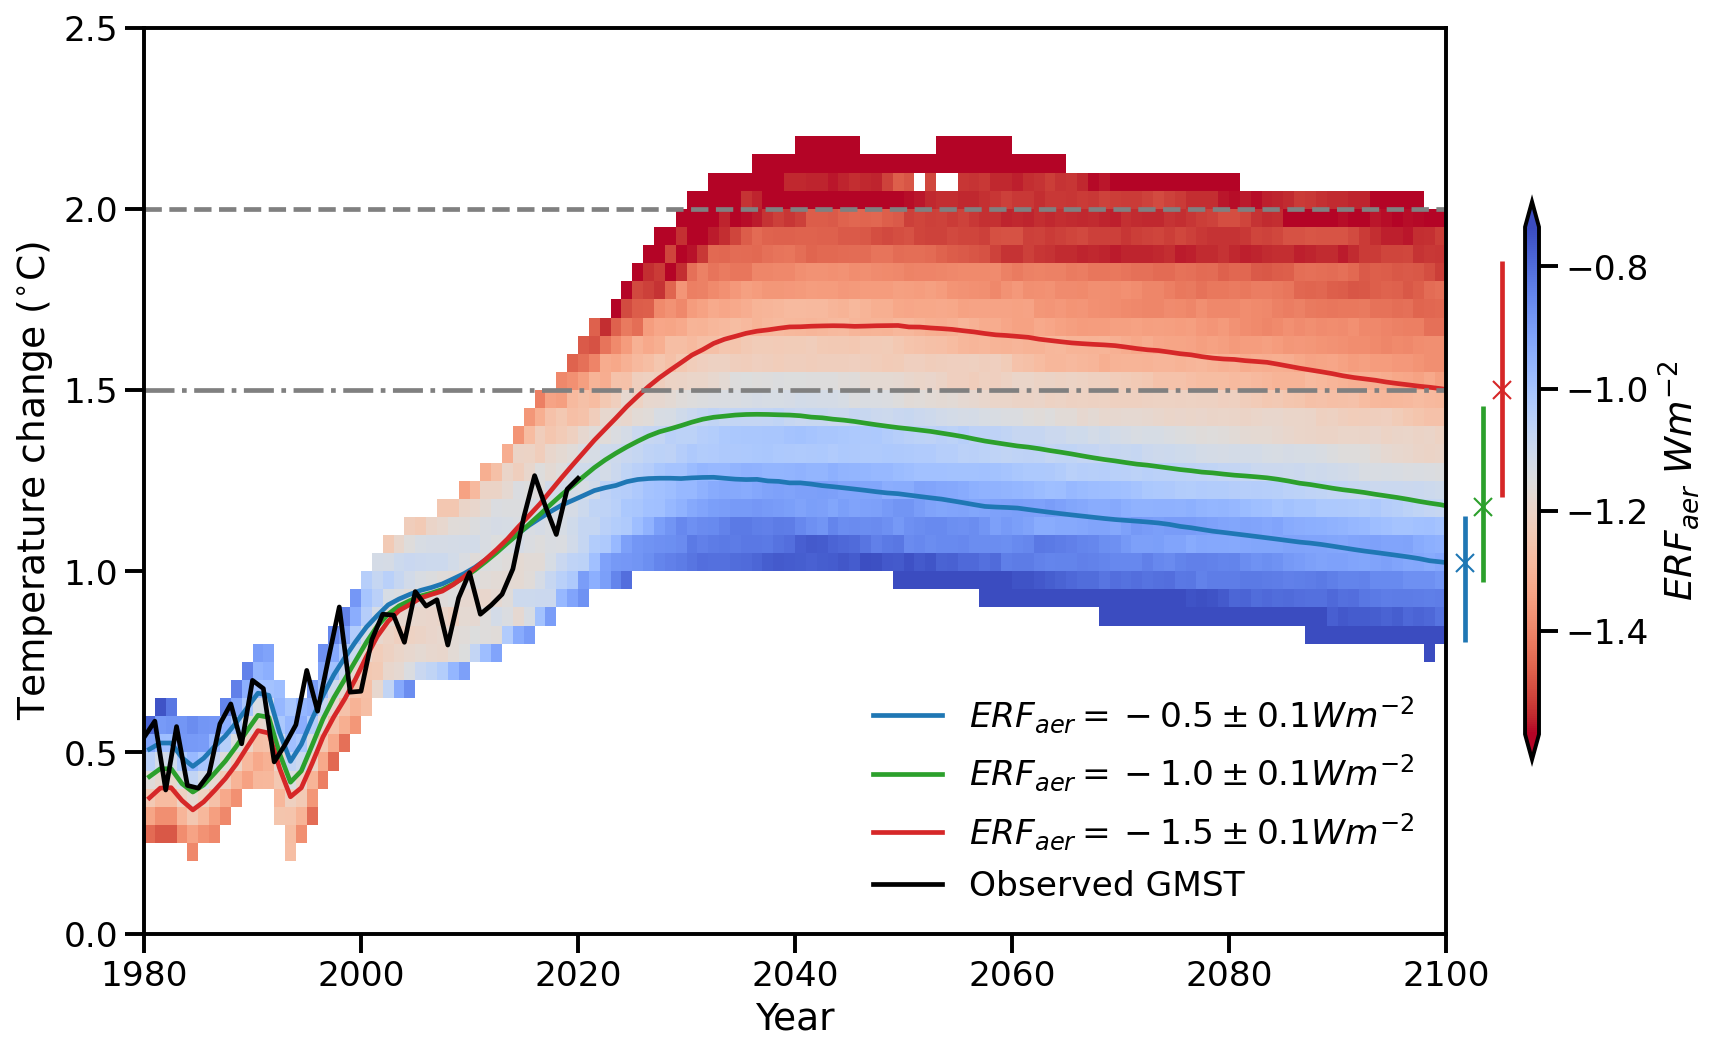

In [14]:

with sns.plotting_context('talk'):

    normed_temp_prob = (temp_prob/temp_prob.max(axis=0))
    
    def get_mean_erf(s):
        mean = binned_statistic(s, mean_erfs, bins=bins, statistic='mean')[0]
        count = np.histogram(s, bins=bins, density=True)[0]
        return np.where(count>0.1, mean, np.nan)
#         return mean
    
    fig = plt.figure(figsize=(12,8), dpi=150)
    
    gs = fig.add_gridspec(1, 15,wspace=0.)
    ax = fig.add_subplot(gs[0,:-1])

    divnorm = TwoSlopeNorm(*mean_erfs.quantile([0.5, 0.1, 0.9]).values)
    
    # p=plt.pcolormesh(ssp_119_erf.index[230:330], bins, np.stack(res)[230:330].T, cmap='RdBu', vmin=-1.5, vmax=-0.5)#, edgecolor='face', shading='auto')
    p=plt.pcolormesh(ssp_119_T[1980:].index, points, 
                     ssp_119_T.apply(get_mean_erf, axis=1, result_type='expand')[1980:].values.T,
                    cmap='coolwarm_r', norm=divnorm)
    

    ssp_119_T.loc[1980:, erf_constraints.weak_aer.values].median(axis=1).plot(label='$ERF_{aer}=-0.5\pm0.1Wm^{-2}$', c=colors['weak'])
    ssp_119_T.loc[1980:, erf_constraints.mid_aer.values].median(axis=1).plot(label='$ERF_{aer}=-1.0\pm0.1Wm^{-2}$', c=colors['mid'])
    ssp_119_T.loc[1980:, erf_constraints.strong_aer.values].median(axis=1).plot(label='$ERF_{aer}=-1.5\pm0.1Wm^{-2}$', c=colors['strong'])
    
    # Save these for the next plot...
    handles, labels = plt.gca().get_legend_handles_labels()
    
    observations.loc[1980:].rename(columns=dict(GMST='Observed GMST')).plot(ax=plt.gca(), color='k')
    
    plt.gca().axhline(1.5, ls='-.', c='grey')
    plt.gca().axhline(2, ls='--', c='grey')
    plt.setp(plt.gca(), xlim=[1980, 2100], xlabel='Year', ylabel='Temperature change ($^{\circ}$C)')
    plt.legend(frameon=False)
    
    # Do the end of century ranges
    ax1 = fig.add_subplot(gs[0,-1])
    ax1.errorbar([-1.],
                 ssp_119_T.iloc[-1, erf_constraints.weak_aer.values].median(),
                 get_robust_errs(ssp_119_T.iloc[-1, erf_constraints.weak_aer.values]), fmt='x', c=colors['weak']
                )
    ax1.errorbar([0],
                 ssp_119_T.iloc[-1, erf_constraints.mid_aer.values].median(),
                 get_robust_errs(ssp_119_T.iloc[-1, erf_constraints.mid_aer.values]), fmt='x', c=colors['mid']
                )
    ax1.errorbar([1.],
                 ssp_119_T.iloc[-1, erf_constraints.strong_aer.values].median(),
                 get_robust_errs(ssp_119_T.iloc[-1, erf_constraints.strong_aer.values]), fmt='x', c=colors['strong']
                )
    ax1.axis('off')
    plt.setp(ax1, xlim=[-2, 2], ylim=[0., 2.5])
    
#     cbar_ax = fig.add_subplot(gs[0,-2])
    
    plt.colorbar(p, extend='both', label='$ERF_{aer}$ $Wm^{-2}$', ax=ax1, aspect=40)

#     plt.tight_layout()
    plt.savefig("../plots/Figure_S1.png", bbox_inches="tight")
    plt.show()
    

In [15]:
joint_df = pd.DataFrame({'ERF':mean_erfs.values, 'ECS': ecs_constraints['ECS'].values, 'T':ssp_126_T[2045:2055].mean(axis=0).values})

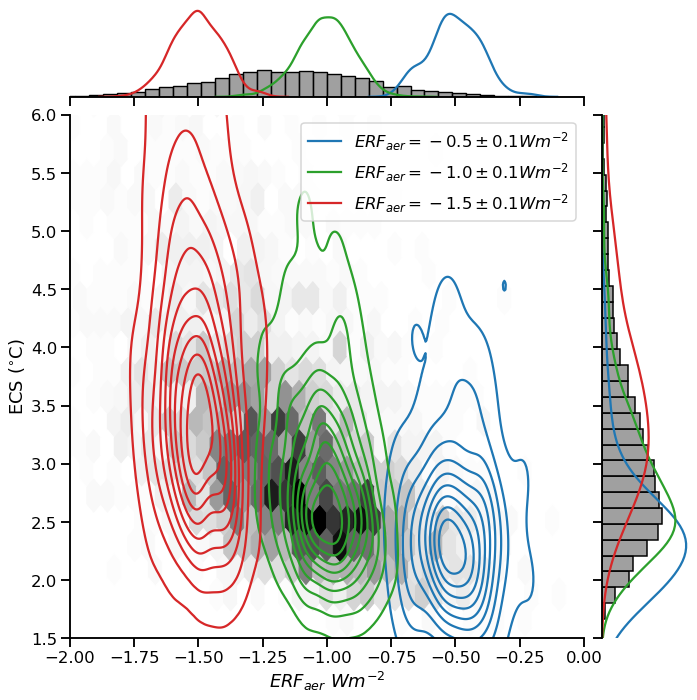

In [16]:

with sns.plotting_context("talk"):

    g = sns.jointplot(data=joint_df, x='ERF', y='ECS', kind='hex', marginal_kws=dict(stat='density', color='gray'), xlim=[-2, 0], ylim=[1.5, 6], height=10, cmap='Greys')

    sns.kdeplot(data=joint_df[erf_constraints.weak_aer.values], x='ERF', y='ECS', ax=g.ax_joint, color=colors['weak'], label='Weak')
    sns.kdeplot(data=joint_df[erf_constraints.weak_aer.values], x='ERF', ax=g.ax_marg_x, color=colors['weak'])
    sns.kdeplot(data=joint_df[erf_constraints.weak_aer.values], y='ECS', ax=g.ax_marg_y, color=colors['weak'])

    sns.kdeplot(data=joint_df[erf_constraints.mid_aer.values], x='ERF', y='ECS', ax=g.ax_joint, color=colors['mid'])
    sns.kdeplot(data=joint_df[erf_constraints.mid_aer.values], x='ERF', ax=g.ax_marg_x, color=colors['mid'])
    sns.kdeplot(data=joint_df[erf_constraints.mid_aer.values], y='ECS', ax=g.ax_marg_y, color=colors['mid'])

    sns.kdeplot(data=joint_df[erf_constraints.strong_aer.values], x='ERF', y='ECS', ax=g.ax_joint, color=colors['strong'])
    sns.kdeplot(data=joint_df[erf_constraints.strong_aer.values], x='ERF', ax=g.ax_marg_x, color=colors['strong'])
    sns.kdeplot(data=joint_df[erf_constraints.strong_aer.values], y='ECS', ax=g.ax_marg_y, color=colors['strong'])

    plt.setp(g.ax_joint, xlabel='$ERF_{aer}$ $Wm^{-2}$', ylabel='ECS ($^{\circ}$C)')
    g.ax_joint.legend(handles, labels)
    plt.savefig("../plots/Figure_2.png", dpi=150)
    plt.show()

    

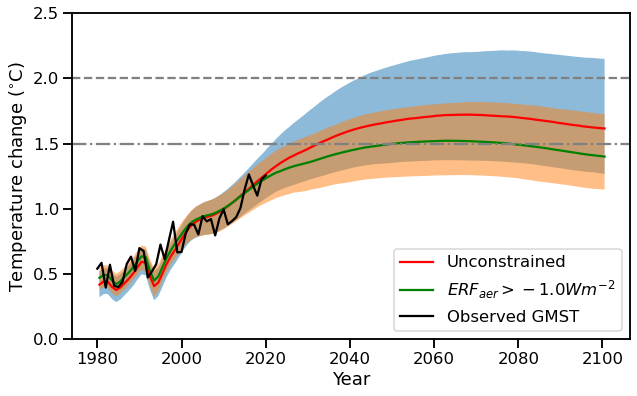

In [17]:
# 1 Wm-2 constraint

with sns.plotting_context('talk'):
    plt.figure(figsize=(10,6))
    
    ssp_126_T.loc[1980:].median(axis=1).plot(label='Unconstrained', c='r')
    plt.fill_between(ssp_126_T.loc[1980:].index, ssp_126_T.loc[1980:].quantile(0.1, axis=1).values, ssp_126_T.loc[1980:].quantile(0.9, axis=1).values, alpha=0.5)
    ssp_126_T.loc[1980:, mean_erfs>-1.].median(axis=1).plot(label='$ERF_{aer}>-1.0Wm^{-2}$', c='g')
    plt.fill_between(ssp_126_T.loc[1980:, mean_erfs>-1.].index, ssp_126_T.loc[1980:, mean_erfs>-1.].quantile(0.1, axis=1).values, ssp_126_T.loc[1980:, mean_erfs>-1.].quantile(0.9, axis=1).values, alpha=0.5)

    # Save these for the next plot...
    handles, labels = plt.gca().get_legend_handles_labels()
    
    observations.loc[1980:].rename(columns=dict(GMST='Observed GMST')).plot(ax=plt.gca(), color='k')
    
    plt.gca().axhline(1.5, ls='-.', c='grey')
    plt.gca().axhline(2, ls='--', c='grey')
    plt.setp(plt.gca(), xlabel='Year', ylabel='Temperature change ($^{\circ}$C)', ylim=[0., 2.5])
    plt.legend()
    plt.show()
    




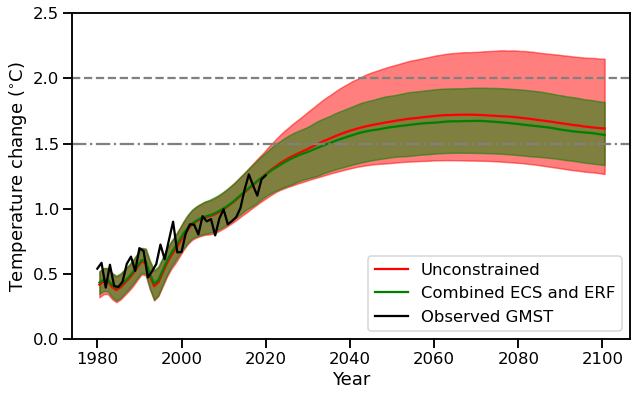

2.16301
1.7456800000000001


In [18]:
# Joint constraint

with sns.plotting_context('talk'):
    plt.figure(figsize=(10,6))
    
    ssp_126_T.loc[1980:].median(axis=1).plot(label='Unconstrained', c='r')
    plt.fill_between(ssp_126_T.loc[1980:].index, ssp_126_T.loc[1980:].quantile(0.1, axis=1).values, ssp_126_T.loc[1980:].quantile(0.9, axis=1).values, alpha=0.5, color='r')
    ssp_126_T.loc[1980:, erf_constraints.mid_aer.values&ecs_constraints.mid_ECS.values].median(axis=1).plot(label='Combined ECS and ERF', c='g')
    plt.fill_between(ssp_126_T.loc[1980:, erf_constraints.mid_aer.values&ecs_constraints.mid_ECS.values].index, ssp_126_T.loc[1980:, erf_constraints.mid_aer.values&ecs_constraints.mid_ECS.values].quantile(0.1, axis=1).values, ssp_126_T.loc[1980:, erf_constraints.mid_aer.values&ecs_constraints.mid_ECS.values].quantile(0.9, axis=1).values, alpha=0.5, color='g')

    # Save these for the next plot...
    handles, labels = plt.gca().get_legend_handles_labels()
    
    observations.loc[1980:].rename(columns=dict(GMST='Observed GMST')).plot(ax=plt.gca(), color='k')
    
    plt.gca().axhline(1.5, ls='-.', c='grey')
    plt.gca().axhline(2, ls='--', c='grey')
    plt.setp(plt.gca(), xlabel='Year', ylabel='Temperature change ($^{\circ}$C)', ylim=[0., 2.5])
    plt.legend()
    plt.savefig("../plots/Figure_S3.png")
    plt.show()
    
print(ssp_126_T.quantile(0.9, axis=1).loc[2090:2100].mean())
print(ssp_126_T.loc[:, mean_erfs>-1.].quantile(0.9, axis=1).loc[2090:2100].mean())

/Users/chris/anaconda3/envs/ar6-aerosol-uncertainty/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
posx and posy should be finite values


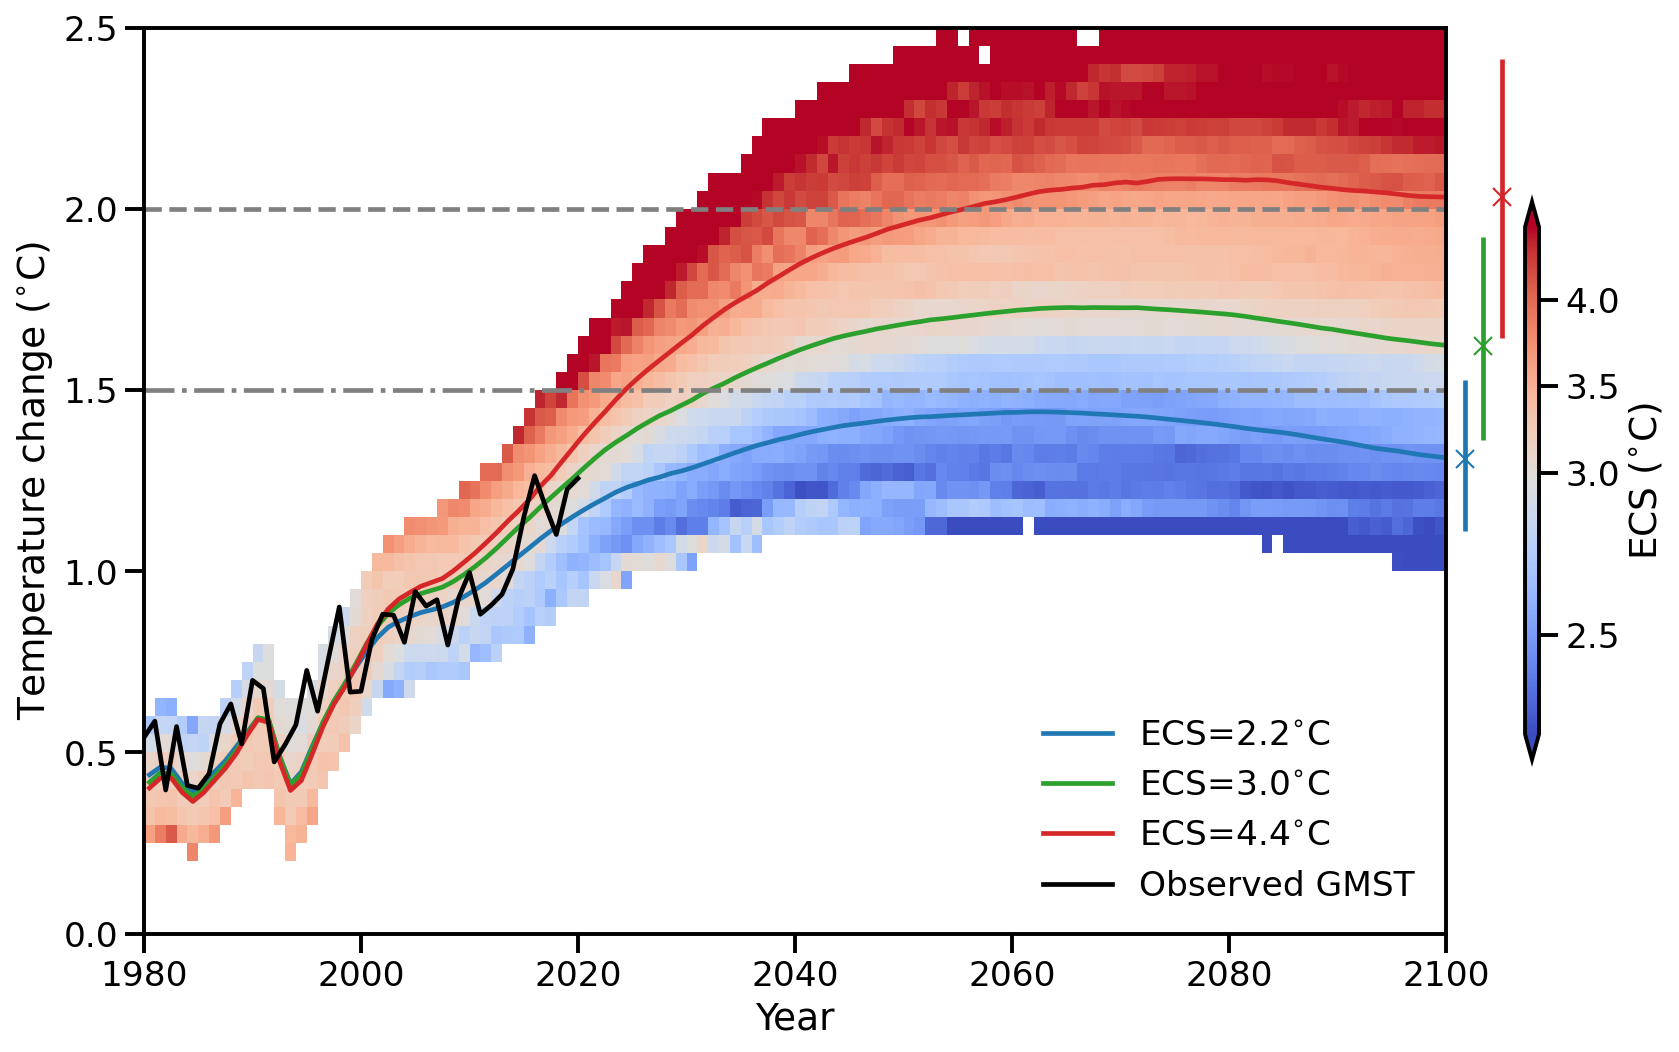

In [19]:


with sns.plotting_context('talk'):

    normed_temp_prob = (temp_prob/temp_prob.max(axis=0))
    
    def get_mean_erf(s):
        mean = binned_statistic(s, ecs_constraints.ECS, bins=bins, statistic='mean')[0]
        count = np.histogram(s, bins=bins, density=True)[0]
        return np.where(count>0.1, mean, np.nan)
#         return mean
    
    fig = plt.figure(figsize=(12,8), dpi=150)
    
    gs = fig.add_gridspec(1, 15,wspace=0.)
    ax = fig.add_subplot(gs[0,:-1])

    divnorm = TwoSlopeNorm(*ecs_constraints.ECS.quantile([0.5, 0.1, 0.9]).values)
    
    # p=plt.pcolormesh(ssp_119_erf.index[230:330], bins, np.stack(res)[230:330].T, cmap='RdBu', vmin=-1.5, vmax=-0.5)#, edgecolor='face', shading='auto')
    p=plt.pcolormesh(ssp_126_T[1980:].index, points, 
                     ssp_126_T.apply(get_mean_erf, axis=1, result_type='expand')[1980:].values.T,
                    cmap='coolwarm', norm=divnorm)
    

    ssp_126_T.loc[1980:, ecs_constraints.low_ECS.values].median(axis=1).plot(label='ECS=$2.2^{\circ}$C', c=colors['weak'])
    ssp_126_T.loc[1980:, ecs_constraints.mid_ECS.values].median(axis=1).plot(label='ECS=$3.0^{\circ}$C', c=colors['mid'])
    ssp_126_T.loc[1980:, ecs_constraints.high_ECS.values].median(axis=1).plot(label='ECS=$4.4^{\circ}$C', c=colors['strong'])
    
    # Save these for the next plot...
    handles, labels = plt.gca().get_legend_handles_labels()
    
    observations.loc[1980:].rename(columns=dict(GMST='Observed GMST')).plot(ax=plt.gca(), color='k')
    
    plt.gca().axhline(1.5, ls='-.', c='grey')
    plt.gca().axhline(2, ls='--', c='grey')
    plt.setp(plt.gca(), xlim=[1980, 2100], xlabel='Year', ylabel='Temperature change ($^{\circ}$C)')
    plt.legend(frameon=False)
    
    # Do the end of century ranges
    ax1 = fig.add_subplot(gs[0,-1])
    ax1.errorbar([-1.],
                 ssp_126_T.iloc[-1, ecs_constraints.low_ECS.values].median(),
                 get_robust_errs(ssp_126_T.iloc[-1, ecs_constraints.low_ECS.values]), fmt='x', c=colors['weak']
                )
    ax1.errorbar([0],
                 ssp_126_T.iloc[-1, ecs_constraints.mid_ECS.values].median(),
                 get_robust_errs(ssp_126_T.iloc[-1, ecs_constraints.mid_ECS.values]), fmt='x', c=colors['mid']
                )
    ax1.errorbar([1.],
                 ssp_126_T.iloc[-1, ecs_constraints.high_ECS.values].median(),
                 get_robust_errs(ssp_126_T.iloc[-1, ecs_constraints.high_ECS.values]), fmt='x', c=colors['strong']
                )
    ax1.axis('off')
    plt.setp(ax1, xlim=[-2, 2], ylim=[0., 2.5])
    
#     cbar_ax = fig.add_subplot(gs[0,-1])
    
    plt.colorbar(p, extend='both', label='ECS ($^{\circ}$C)', ax=ax1, aspect=40)

#     plt.tight_layout()
    plt.savefig("../plots/Figure_S2.png", bbox_inches="tight")
    plt.show()
    

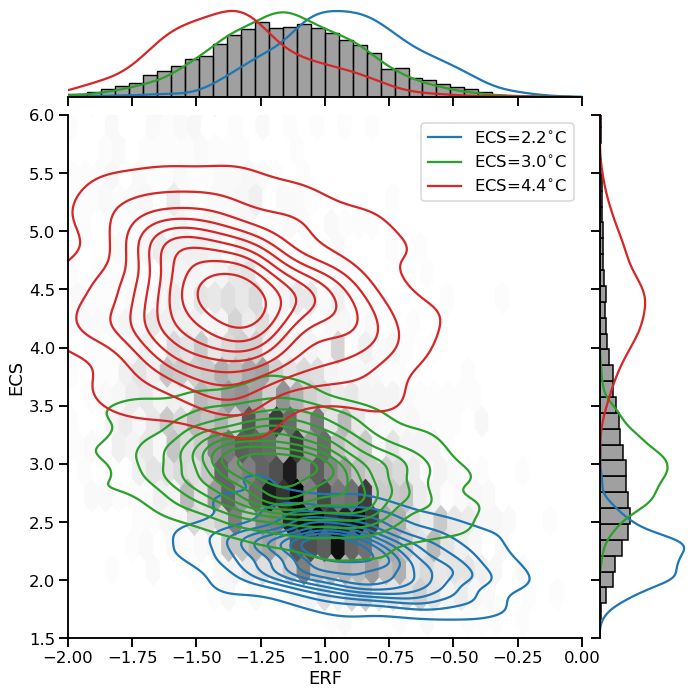

In [20]:
with sns.plotting_context("talk"):

    g = sns.jointplot(data=joint_df, x='ERF', y='ECS', kind='hex', marginal_kws=dict(stat='density', color='gray'), xlim=[-2, 0], ylim=[1.5, 6], height=10, cmap='Greys')

    sns.kdeplot(data=joint_df[ecs_constraints.low_ECS.values], x='ERF', y='ECS', ax=g.ax_joint, color=colors['weak'])
    sns.kdeplot(data=joint_df[ecs_constraints.low_ECS.values], x='ERF', ax=g.ax_marg_x, color=colors['weak'])
    sns.kdeplot(data=joint_df[ecs_constraints.low_ECS.values], y='ECS', ax=g.ax_marg_y, color=colors['weak'])

    sns.kdeplot(data=joint_df[ecs_constraints.mid_ECS.values], x='ERF', y='ECS', ax=g.ax_joint, color=colors['mid'])
    sns.kdeplot(data=joint_df[ecs_constraints.mid_ECS.values], x='ERF', ax=g.ax_marg_x, color=colors['mid'])
    sns.kdeplot(data=joint_df[ecs_constraints.mid_ECS.values], y='ECS', ax=g.ax_marg_y, color=colors['mid'])

    sns.kdeplot(data=joint_df[ecs_constraints.high_ECS.values], x='ERF', y='ECS', ax=g.ax_joint, color=colors['strong'])
    sns.kdeplot(data=joint_df[ecs_constraints.high_ECS.values], x='ERF', ax=g.ax_marg_x, color=colors['strong'])
    sns.kdeplot(data=joint_df[ecs_constraints.high_ECS.values], y='ECS', ax=g.ax_marg_y, color=colors['strong'])

    g.ax_joint.legend(handles, labels)
    plt.savefig("../plots/Figure_S3.png")
    plt.show()


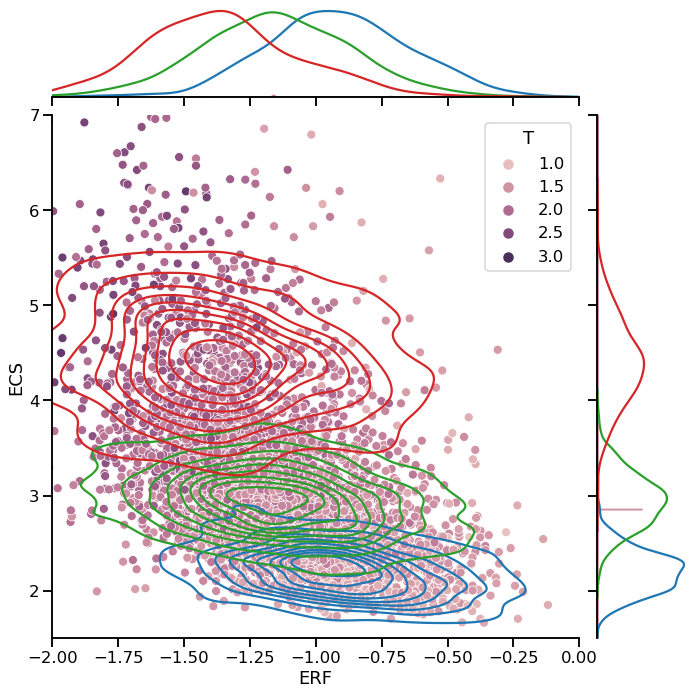

In [21]:
import warnings

with warnings.catch_warnings() as W, sns.plotting_context("talk") as S:
    warnings.simplefilter("ignore")

    g = sns.jointplot(data=joint_df, x='ERF', y='ECS', kind='scatter', xlim=[-2, 0], ylim=[1.5, 7], height=10, hue='T')

    sns.kdeplot(data=joint_df[ecs_constraints.low_ECS.values], x='ERF', y='ECS', ax=g.ax_joint, color=colors['weak'])
    sns.kdeplot(data=joint_df[ecs_constraints.low_ECS.values], x='ERF', ax=g.ax_marg_x, color=colors['weak'])
    sns.kdeplot(data=joint_df[ecs_constraints.low_ECS.values], y='ECS', ax=g.ax_marg_y, color=colors['weak'])

    sns.kdeplot(data=joint_df[ecs_constraints.mid_ECS.values], x='ERF', y='ECS', ax=g.ax_joint, color=colors['mid'])
    sns.kdeplot(data=joint_df[ecs_constraints.mid_ECS.values], x='ERF', ax=g.ax_marg_x, color=colors['mid'])
    sns.kdeplot(data=joint_df[ecs_constraints.mid_ECS.values], y='ECS', ax=g.ax_marg_y, color=colors['mid'])

    sns.kdeplot(data=joint_df[ecs_constraints.high_ECS.values], x='ERF', y='ECS', ax=g.ax_joint, color=colors['strong'])
    sns.kdeplot(data=joint_df[ecs_constraints.high_ECS.values], x='ERF', ax=g.ax_marg_x, color=colors['strong'])
    sns.kdeplot(data=joint_df[ecs_constraints.high_ECS.values], y='ECS', ax=g.ax_marg_y, color=colors['strong'])
